In [1]:
import sys
anomaLEAF_path = 'src'
sys.path.append(anomaLEAF_path)


from anomaLEAF.utils import dataset_loader
from anomaLEAF.utils import post_processing
from anomaLEAF.model import colour_gan

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from scipy.ndimage import gaussian_filter
import tensorflow as tf
import tensorflow_io as tfio

2023-09-11 23:03:17.763974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 23:03:17.852665: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 23:03:17.853792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 23:03:19.275442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Visualising Reduced Images

To use autonomous feature extraction, we want to train a generator to recreate full colour images from a reduced colour space. Ideally, the generator will be able to perfectly recreate colouration in healthy leaves, regardless of lighting. To this end, it is worthwhile finding which image channel(s) encapsulate the most information for a healthy leaf.

In [3]:
image_file = '/home/pumpedchicken/University/Thesis/anomaLEAF/data/test/fe60a756-1145-4ed4-9496-af5f387f0222___Crnl_L.Mold 8965_final_masked.jpg'

In [2]:
# Load an image in BGR format
image = cv2.imread(image_file)

# Split the RGB image into its individual channels
b_channel, g_channel, r_channel = cv2.split(image)

# Convert the image to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Split the LAB image into its individual channels
l_channel, a_channel, b_channel_lab = cv2.split(lab_image)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Split the HSV image into its individual channels
h_channel, s_channel, v_channel = cv2.split(hsv_image)

# Create a 3x4 grid to display the images and channels
fig, axs = plt.subplots(3, 4, figsize=(12, 9))

# Display the RGB image and its channels
axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('RGB Image')
axs[0, 1].imshow(r_channel, cmap='gray')
axs[0, 1].set_title('Red Channel')
axs[0, 2].imshow(g_channel, cmap='gray')
axs[0, 2].set_title('Green Channel')
axs[0, 3].imshow(b_channel, cmap='gray')
axs[0, 3].set_title('Blue Channel')

# Display the LAB image and its channels
axs[1, 0].imshow(cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB))
axs[1, 0].set_title('LAB Image')
axs[1, 1].imshow(l_channel, cmap='gray')
axs[1, 1].set_title('L Channel')
axs[1, 2].imshow(a_channel, cmap='gray')
axs[1, 2].set_title('A Channel')
axs[1, 3].imshow(b_channel_lab, cmap='gray')
axs[1, 3].set_title('B Channel LAB')

# Display the HSV image and its channels
axs[2, 0].imshow(cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB))
axs[2, 0].set_title('HSV Image')
axs[2, 1].imshow(h_channel, cmap='gray')
axs[2, 1].set_title('H Channel')
axs[2, 2].imshow(s_channel, cmap='gray')
axs[2, 2].set_title('S Channel')
axs[2, 3].imshow(v_channel, cmap='gray')
axs[2, 3].set_title('V Channel')

for ax in axs.flat:
    ax.axis('off')

plt.show()


NameError: name 'cv2' is not defined

We want to focus on reconstructing the colour of the image, regardless of lighting. It is therefore recommended to use a reduced image with only the luminance channel intact

# Colour Reconstruction

Now we know what reduced features will be using as input for our generator, we can begin to train the generator. The `anomaleaf` module contains helper functions to assist with this

## Dataset Creation

To train the generator, we will only be using normal samples, however an anomalous directory can also be included to provide examples of how the generator performs when reconstructing anomalous examples

In [2]:
dataset = dataset_loader.Dataset(normal_dir='/home/pumpedchicken/University/Thesis/anomaLEAF/data/train',
                                  anomalous_dir='/home/pumpedchicken/University/Thesis/anomaLEAF/data/test',
                                  colourspace_transformation = tfio.experimental.color.rgb_to_lab, img_size = 256, batch_size = 126, channels=[0])

Normal Dataset Directory: /home/pumpedchicken/University/Thesis/anomaLEAF/data/train
Normal Reduced Image Size: (256, 256, 1)
Normal Full Image Size: (256, 256, 3)
Normal Extracted Channel Indices: [0]
Normal Batch Size: 126
Normal Number of Batches: 2
Normal Colourspace Transformation: <function rgb_to_lab at 0x7f0a4fcc7910>

Anomalous Dataset Directory: /home/pumpedchicken/University/Thesis/anomaLEAF/data/test
Anomalous Reduced Image Size: (256, 256, 1)
Anomalous Full Image Size: (256, 256, 3)
Anomalous Extracted Channel Indices: [0]
Anomalous Batch Size: 126
Anomalous Number of Batches: 8
Anomalous Colourspace Transformation: <function rgb_to_lab at 0x7f0a4fcc7910>



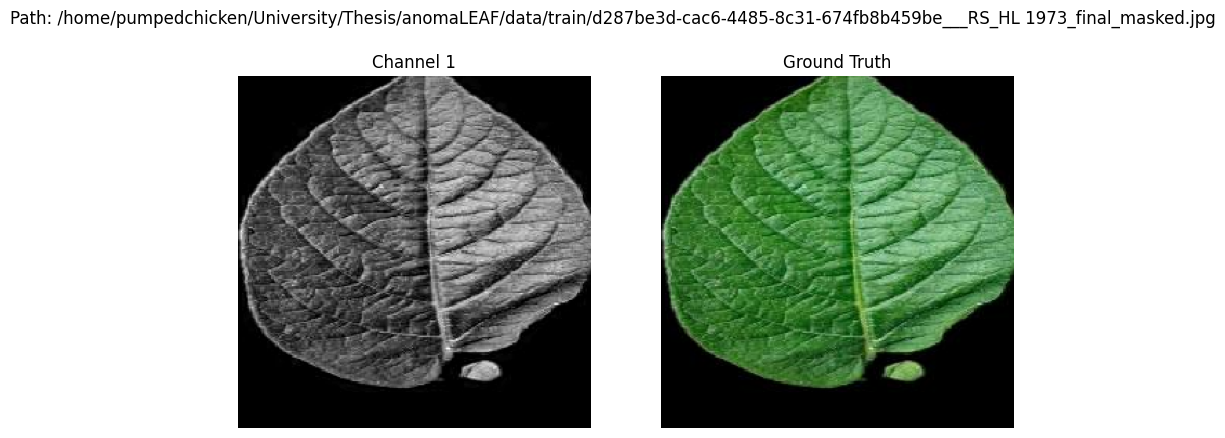

In [3]:
for inpt, grnd_truth, path in dataset.normal_dataset.take(1):
    inpt_size = inpt.shape[1:]
    grnd_truth_size = grnd_truth.shape[1:]
    num_channels = inpt.shape[-1]

    # Calculate the number of subplots based on the number of channels
    num_subplots = num_channels + 1  # Add 1 for the ground truth

    fig, axes = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5))

    # Plot each channel separately
    for i in range(num_channels):
        channel = inpt[0, ..., i]
        axes[i].imshow(channel.numpy(), cmap='gray')
        axes[i].set_title(f'Channel {i + 1}')
        axes[i].axis('off')

    # Display ground truth image
    axes[num_channels].imshow(grnd_truth[0] * 255)
    axes[num_channels].set_title("Ground Truth")
    axes[num_channels].axis("off")

    # Print the path above all images
    plt.suptitle("Path: " + path[0].numpy().decode("utf-8"))

    plt.show()


## Training the Generator

In [4]:
model = colour_gan.ColourGAN(full_shape=grnd_truth_size,reduced_shape=inpt_size)

In [5]:
# tf.keras.utils.plot_model(model.generator, show_shapes=True, dpi=64)

In [6]:
# tf.keras.utils.plot_model(model.discriminator, show_shapes=True, dpi=64)

2023-09-11 23:03:32.040120: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 528482304 exceeds 10% of free system memory.
2023-09-11 23:03:32.218971: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 528482304 exceeds 10% of free system memory.


2023-09-11 23:03:53.981906: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 528482304 exceeds 10% of free system memory.
2023-09-11 23:03:54.087505: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 528482304 exceeds 10% of free system memory.
2023-09-11 23:03:57.184912: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 528482304 exceeds 10% of free system memory.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


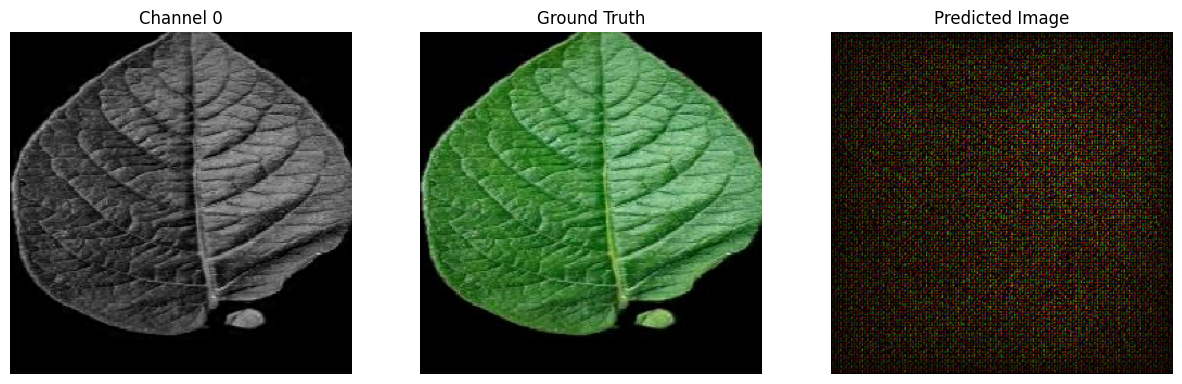

In [7]:
colour_gan.generate_images(model.generator, inpt, grnd_truth)